In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
tweets=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalMSTF.csv')

In [9]:
print(tweets)

           date        Open        High         Low       Close   Adj Close  \
0    2020-12-28  224.449997  226.029999  223.020004  224.960007  222.629654   
1    2020-12-29  226.309998  227.179993  223.580002  224.149994  221.828049   
2    2020-12-30  225.229996  225.630005  221.470001  221.679993  219.383621   
3    2020-12-31  221.699997  223.000000  219.679993  222.419998  220.115967   
4    2021-01-04  222.529999  223.000000  214.809998  217.690002  215.434967   
..          ...         ...         ...         ...         ...         ...   
250  2021-12-23  332.750000  336.390015  332.730011  334.690002  333.999390   
251  2021-12-27  335.459991  342.480011  335.429993  342.450012  341.743378   
252  2021-12-28  343.149994  343.809998  340.320007  341.250000  340.545837   
253  2021-12-29  341.299988  344.299988  339.679993  341.950012  341.244415   
254  2021-12-30  341.910004  343.130005  338.820007  339.320007  338.619843   

         Volume  Unnamed: 7  Goal II: Open t+1 - Op

Loading Dataset

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalMSTF.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,Goal II: Open t+1 - Open t,Goal II: Open t+1 - Close t,P_mean,P_sum,twt_count
0,2020-12-28,224.449997,226.029999,223.020004,224.960007,222.629654,17933500.0,NaN,1.0,1,-0.150538,-14,93
1,2020-12-29,226.309998,227.179993,223.580002,224.149994,221.828049,17403200.0,NaN,-1.0,1,-0.153846,-10,65
2,2020-12-30,225.229996,225.630005,221.470001,221.679993,219.383621,20272300.0,NaN,-1.0,1,-0.160000,-8,50
3,2020-12-31,221.699997,223.000000,219.679993,222.419998,220.115967,20942100.0,NaN,1.0,1,-0.302632,-23,76
4,2021-01-04,222.529999,223.000000,214.809998,217.690002,215.434967,37130100.0,NaN,-1.0,-1,-0.127660,-6,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2021-12-23,332.750000,336.390015,332.730011,334.690002,333.999390,19617800.0,NaN,1.0,1,-0.102564,-12,117
251,2021-12-27,335.459991,342.480011,335.429993,342.450012,341.743378,19947000.0,NaN,1.0,1,-0.046875,-6,128
252,2021-12-28,343.149994,343.809998,340.320007,341.250000,340.545837,15661500.0,NaN,-1.0,1,-0.183333,-22,120
253,2021-12-29,341.299988,344.299988,339.679993,341.950012,341.244415,15042000.0,NaN,1.0,-1,-0.260163,-32,123


Time series

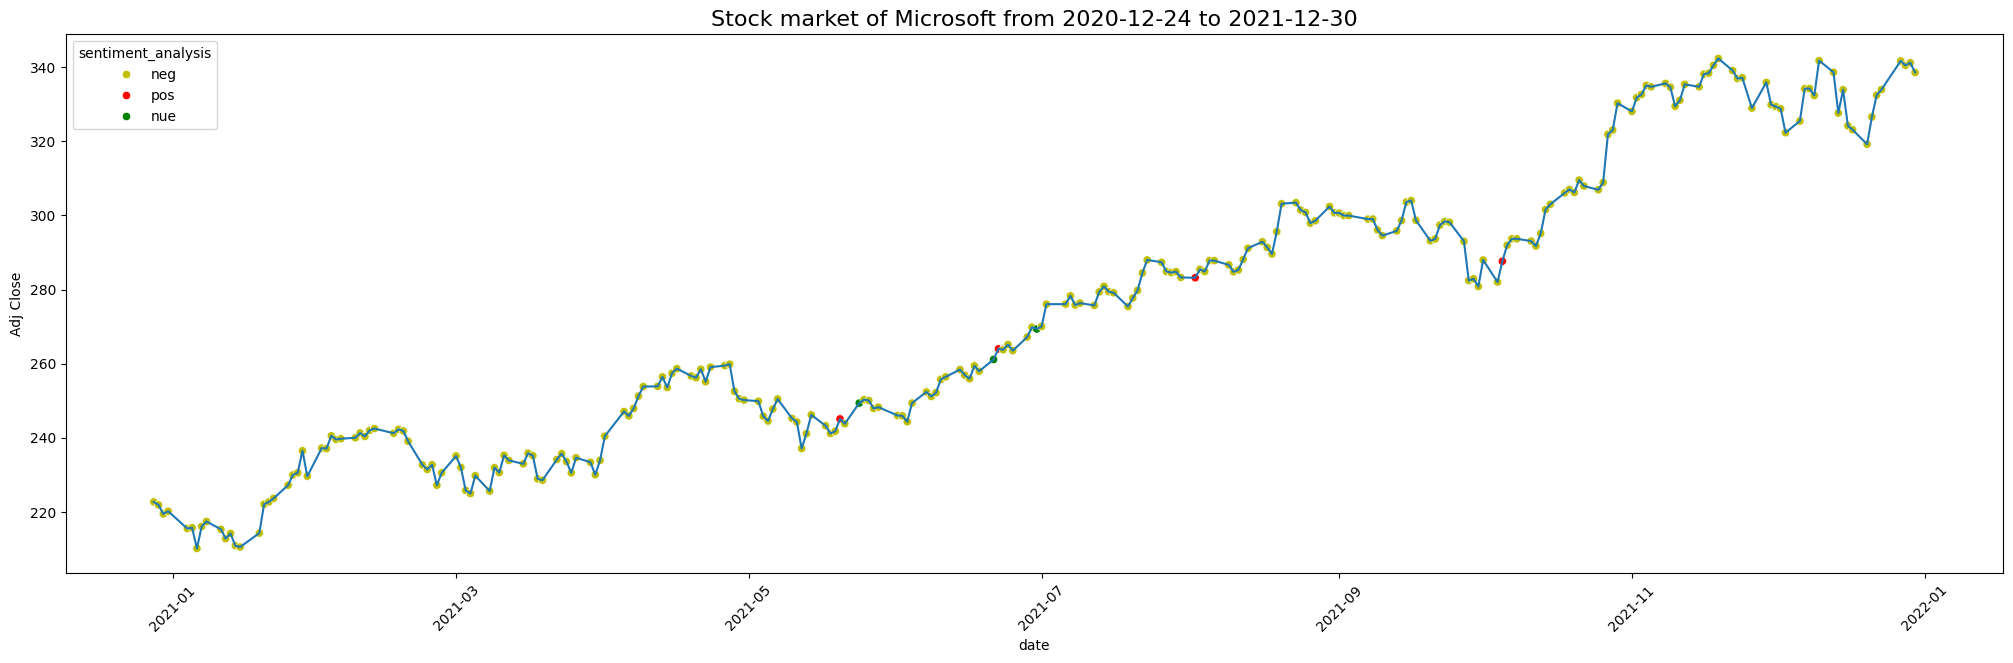

In [11]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Microsoft from 2020-12-24 to 2021-12-30",fontsize=16);

In [12]:
df['sentiment_analysis'].value_counts()

neg    248
pos      4
nue      3
Name: sentiment_analysis, dtype: int64

In [13]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,Goal II: Open t+1 - Open t,Goal II: Open t+1 - Close t,P_mean,P_sum,twt_count,sentiment_analysis
14,2021-01-19,213.750000,216.979996,212.630005,216.440002,214.197922,30480900.0,NaN,1.0,1,-0.065041,-8,123,neg
15,2021-01-20,217.699997,225.789993,217.289993,224.339996,222.016068,37777300.0,NaN,1.0,1,-0.048611,-7,144,neg
16,2021-01-21,224.699997,226.300003,222.419998,224.970001,222.639572,30709400.0,NaN,1.0,1,-0.066116,-8,121,neg
17,2021-01-22,227.080002,230.070007,225.800003,225.949997,223.609390,30172700.0,NaN,1.0,1,-0.041176,-7,170,neg
18,2021-01-25,229.119995,229.779999,224.220001,229.529999,227.152313,33152100.0,NaN,1.0,1,-0.073171,-9,123,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2021-12-23,332.750000,336.390015,332.730011,334.690002,333.999390,19617800.0,NaN,1.0,1,-0.102564,-12,117,neg
251,2021-12-27,335.459991,342.480011,335.429993,342.450012,341.743378,19947000.0,NaN,1.0,1,-0.046875,-6,128,neg
252,2021-12-28,343.149994,343.809998,340.320007,341.250000,340.545837,15661500.0,NaN,-1.0,1,-0.183333,-22,120,neg
253,2021-12-29,341.299988,344.299988,339.679993,341.950012,341.244415,15042000.0,NaN,1.0,-1,-0.260163,-32,123,neg


In [14]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2021-01-19,213.750000,216.979996,212.630005,216.440002,30480900.0,214.197922,-0.065041
2021-01-20,217.699997,225.789993,217.289993,224.339996,37777300.0,222.016068,-0.048611
2021-01-21,224.699997,226.300003,222.419998,224.970001,30709400.0,222.639572,-0.066116
2021-01-22,227.080002,230.070007,225.800003,225.949997,30172700.0,223.609390,-0.041176
2021-01-25,229.119995,229.779999,224.220001,229.529999,33152100.0,227.152313,-0.073171
...,...,...,...,...,...,...,...
2021-12-23,332.750000,336.390015,332.730011,334.690002,19617800.0,333.999390,-0.102564
2021-12-27,335.459991,342.480011,335.429993,342.450012,19947000.0,341.743378,-0.046875
2021-12-28,343.149994,343.809998,340.320007,341.250000,15661500.0,340.545837,-0.183333


LSTM Model


Data scaling for LSTM because uses sigmoid and tanh that are sensitive to magnitude

In [15]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

In [16]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.        , 0.        , 0.        , ..., 0.29624051, 0.        ,
        0.6239876 ],
       [0.0301826 , 0.06639533, 0.03596502, ..., 0.42660228, 0.06098203,
        0.65761975],
       [0.0836708 , 0.07023895, 0.07555756, ..., 0.30032303, 0.06584541,
        0.62178692],
       ...,
       [0.98876747, 0.95583681, 0.98549043, ..., 0.03146842, 0.98552175,
        0.38183619],
       [0.97463126, 0.95952955, 0.98055091, ..., 0.02040007, 0.9909707 ,
        0.22456258],
       [0.9792925 , 0.95071213, 0.97391368, ..., 0.03741799, 0.97049887,
        0.3003488 ]])

As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.

In [17]:
import numpy as np

In [18]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (236, 5, 7).
TrainY shape = (236, 1, 2).


Train test split for LSTM

In [19]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((188, 5, 6), (188, 5, 7))

Train validation split for LSTM

In [20]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((169, 5, 6), (169, 5, 7))

In [21]:
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

Model architecture

In [22]:
# def build_model(input_shape):
#     tf.random.set_seed(seed)
#     cnn_lstm_model = Sequential()

#     cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
#     cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

#     cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
#     cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
#     # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

#     cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
#     cnn_lstm_model.add(Dropout(0.2))
#     cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
#     cnn_lstm_model.add(Dropout(0.2))

#     cnn_lstm_model.add(Dense(32, activation='relu'))


#     cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))
#     cnn_lstm_model.add(Dense(2, activation='linear'))

#     # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

#     cnn_lstm_model.compile(optimizer='adam', loss='mse')
#     cnn_lstm_model.summary()
#     return cnn_lstm_model

def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))
    cnn_lstm_model.add(Dense(2, activation='linear'))  # Adjusted to output 2 values

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [23]:
# import numpy as np
# # Assuming you have data stored in NumPy arrays
# # Define your training and validation data
# X_train_lstm_without_twitter = np.random.rand(100, 10, 5)  # Example training data with shape (100, 10, 5)
# y_train_lstm_without_twitter = np.random.randint(2, size=(100))  # Example training labels
# X_val_lstm_without_twitter = np.random.rand(20, 10, 5)  # Example validation data with shape (20, 10, 5)
# y_val_lstm_without_twitter = np.random.randint(2, size=(20,))  # Example validation labels

# # fit the model

# cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
# cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

# history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


# history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

import numpy as np

# Generate random example training and validation data
X_train_lstm_without_twitter = np.random.rand(100, 10, 5)  # Example training data with shape (100, 10, 5)
X_val_lstm_without_twitter = np.random.rand(20, 10, 5)  # Example validation data with shape (20, 10, 5)

# Generate random example labels for regression
y_train_lstm_without_twitter = np.random.rand(100, 1, 2)  # Example training labels with shape (100, 1, 2)
y_val_lstm_without_twitter = np.random.rand(20, 1, 2)  # Example validation labels with shape (20, 1, 2)

# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1)

# Print training history for the model withoutout Twitter data
print("\nTraining history without Twitter data:")
print(history_without_twitter.history)


X_train_lstm_with_twitter = np.random.rand(100, 10, 5)  # Example training data with shape (100, 10, 5)
X_val_lstm_with_twitter = np.random.rand(20, 10, 5)  # Example validation data with shape (20, 10, 5)

# Generate random example labels for regression
y_train_lstm_with_twitter = np.random.rand(100, 1, 2)  # Example training labels with shape (100, 1, 2)
y_val_lstm_with_twitter = np.random.rand(20, 1, 2)  # Example validation labels with shape (20, 1, 2)

# Fit the model
cnn_lstm_model_with_twitter = build_model((X_train_lstm_with_twitter.shape[1], X_train_lstm_with_twitter.shape[2]))

history_with_twitter = cnn_lstm_model_with_twitter.fit(
    X_train_lstm_with_twitter, y_train_lstm_with_twitter,
    epochs=50, batch_size=64,
    validation_data=(X_val_lstm_with_twitter, y_val_lstm_with_twitter),
    verbose=1,
)

# Print training history for the model with Twitter data
print("\nTraining history with Twitter data:")
print(history_with_twitter.history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 128)            1408      
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 2, 512)            659456    
 al)                                                             
                                                        

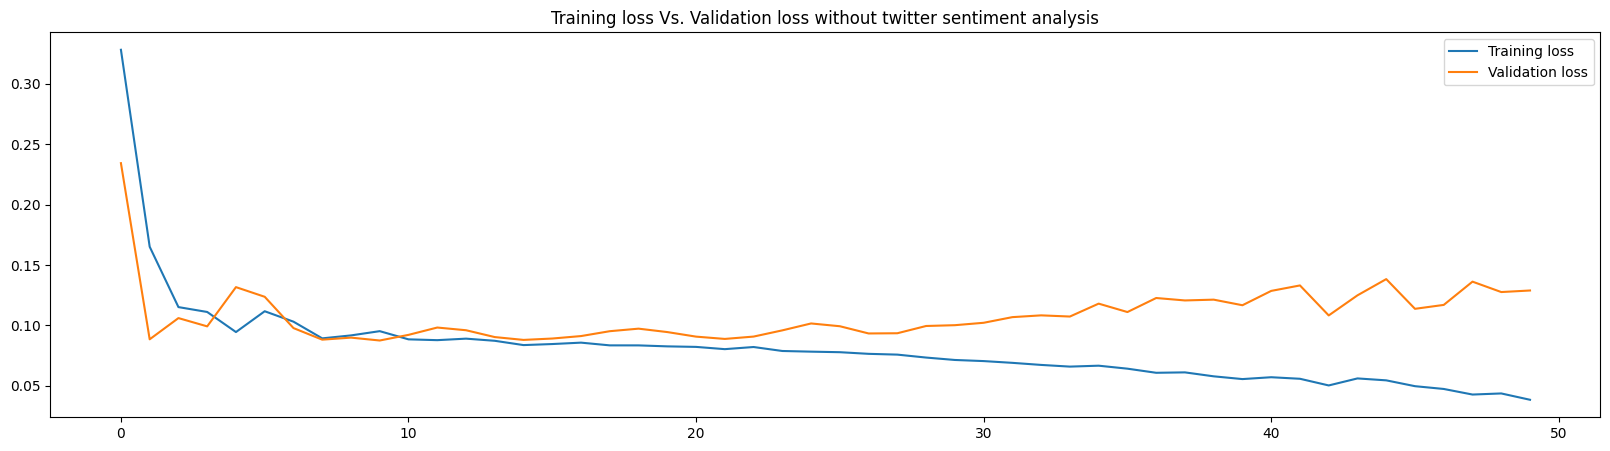

In [24]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

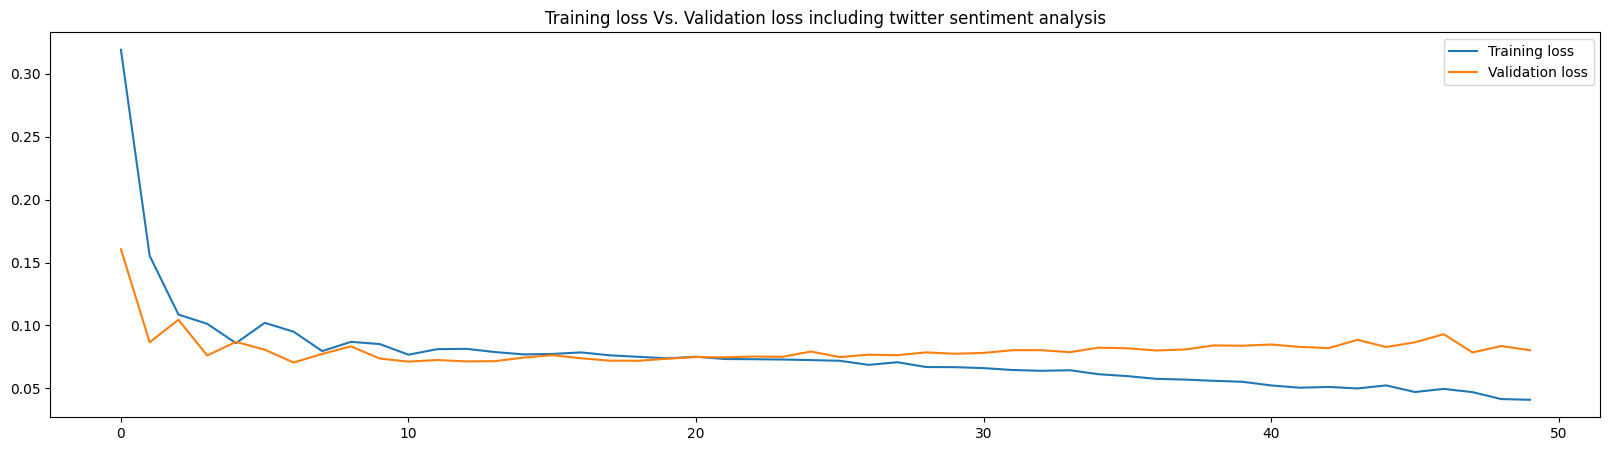

In [25]:
plt.figure(figsize=(20,5))
plt.plot(history_with_twitter.history['loss'], label='Training loss')
plt.plot(history_with_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()